In [521]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

%matplotlib inline
pd.plotting.register_matplotlib_converters()

In [522]:
# Function is used to randomly reduce a dataset's sample size
# Returns a df that is reduced_size % the size of the original dataset
# ====================================================================
# reduced_size: A percentage in range [0,1] that represents ratio of reduced size to the original (redice/original)
# df: the df that will be reduced

def reduce_df(reduced_size, df):
    if reduced_size >= 0 and reduced_size <= 1:
        n = df.shape[0]
        num_drop = int(n * (1-reduced_size))
        n_list = [i for i in range(n)]
        np.random.shuffle(n_list)
        drop_list = n_list[0:num_drop]
        return df.drop(drop_list)
    
    else:
        print('NO SAMPLES REMOVED!\nEnter a valid reduction percentage in range [0,1]\n')
        return df

In [523]:
df_train = pd.read_csv('../heartECG_data/mitbih_train.csv')
n_orig = df_train.shape[0]
df_train = reduce_df(0.5,df_train) #shrink df by 60% of it's original size (# samples)
n_new = df_train.shape[0]
n_change = n_orig - n_new
n_change_percent = round(n_new/n_orig,2)

print('Orig # samples:', n_orig)
print('New # samples:', n_new)
print('# samples removed:', n_change)
print('Removed Ratio (should equal reduced_size param):', n_change_percent)

Orig # samples: 87553
New # samples: 43777
# samples removed: 43776
Removed Ratio (should equal reduced_size param): 0.5


In [524]:
cols = [i for i in range(188)]
df_train.columns = cols
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.423611,0.791667,1.000000,0.256944,0.000000,0.277778,0.465278,0.520833,0.472222,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.874214,0.849057,0.480084,0.058700,0.090147,0.310273,0.387841,0.385744,0.389937,0.392034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [525]:
X = np.array(df_train.iloc[:,0:-1])
y = df_train.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('# training samples:', X_train.shape[0])
print('# test samples:', X_test.shape[0])


n_steps = 187
# n_samples = X_train.shape[0]
# n_features = X_train.shape[1]
n_features = 1

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
val_data = (X_test, y_test)

# training samples: 32832
# test samples: 10945


In [533]:
def gen_cnn(activation_method, normalize, dropout):
    model = keras.models.Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation=activation_method, input_shape=(187, 1)))
    
    if normalize:
        model.add(BatchNormalization())
    
    model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation=activation_method))
    if normalize:
        model.add(BatchNormalization())
    
    model.add(MaxPooling1D(pool_size=2))
    if normalize:
        model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(100, activation=activation_method))
    if normalize:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.35))
    model.add(Dense(1, activation=activation_method))
    
    model.summary()
    return model

def gen_graph(history):
    n = len(history['accuracy'])
    
    fig = plt.figure(figsize = (16,8))
    fig.suptitle("Model Accuracy & Loss Results", fontsize="x-large")
    
    fig1 = plt.subplot(2,2,1)
    fig1.plot(history['accuracy'], c='b', label='Train Acc')
    fig1.plot(history['val_accuracy'], c='orange', label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(np.arange(n,step=5))
    ax = plt.gca()
    ax.set_xlim([0, n-1])
    plt.legend(loc='lower right')

    fig2 = plt.subplot(2,2,2)
    fig2.plot(history['loss'], c='r', label='Train Loss')
    fig2.plot(history['val_loss'], c='orange', label='Val Loss')
    plt.title('MSE Loss')
    plt.xlabel('Epoch')
    plt.xticks(np.arange(n,step=5))
    ax = plt.gca()
    ax.set_xlim([0, n-1])
    plt.legend(loc='upper right')
    
    plt.show()
    
def get_acc(model, val_data):
    X_test = val_data[0]
    y_test = val_data[1]
    y_hat = model.predict(X_test)
    y_hat = np.array([pred[0] for pred in y_hat])
    y_hat = np.round(np.sqrt(np.square(y_hat)))
    acc = round(accuracy_score(y_test, y_hat),4)
    print('Final Val Accuracu:', acc)
    return acc

Model: "sequential_158"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_340 (Conv1D)          (None, 187, 64)           192       
_________________________________________________________________
batch_normalization_307 (Bat (None, 187, 64)           256       
_________________________________________________________________
conv1d_341 (Conv1D)          (None, 187, 32)           2080      
_________________________________________________________________
batch_normalization_308 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_128 (MaxPoolin (None, 93, 32)            0         
_________________________________________________________________
batch_normalization_309 (Bat (None, 93, 32)            128       
_________________________________________________________________
flatten_144 (Flatten)        (None, 2976)           

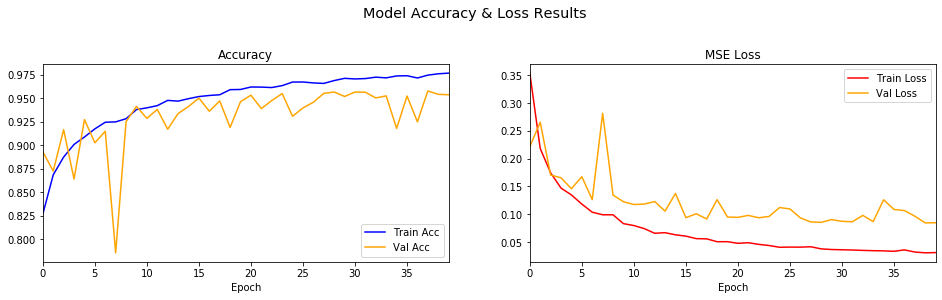

Final Val Accuracu: 0.9537


0.9537

In [534]:
nadam = keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model = gen_cnn('relu', True, False)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
nadam_history = model.fit(X_train, y_train, epochs=40, verbose=1, validation_data=val_data)
gen_graph(nadam_history.history)
get_acc(model, val_data)

Model: "sequential_159"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_342 (Conv1D)          (None, 187, 64)           192       
_________________________________________________________________
batch_normalization_311 (Bat (None, 187, 64)           256       
_________________________________________________________________
conv1d_343 (Conv1D)          (None, 187, 32)           2080      
_________________________________________________________________
batch_normalization_312 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_129 (MaxPoolin (None, 93, 32)            0         
_________________________________________________________________
batch_normalization_313 (Bat (None, 93, 32)            128       
_________________________________________________________________
flatten_145 (Flatten)        (None, 2976)           

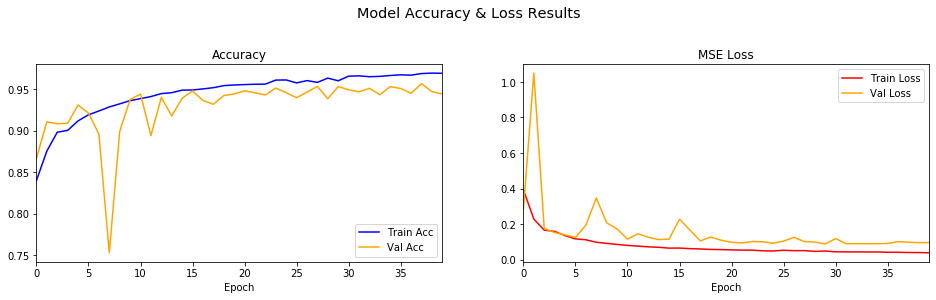

Final Val Accuracu: 0.9444


0.9444

In [535]:
adagrad = keras.optimizers.Adagrad(learning_rate=0.1)
model = gen_cnn('relu', True, False)
model.compile(loss='mse', optimizer=adagrad, metrics=['accuracy'])
adagrad_history = model.fit(X_train, y_train, epochs=40, verbose=1, validation_data=val_data)
gen_graph(adagrad_history.history)
get_acc(model, val_data)

Model: "sequential_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_344 (Conv1D)          (None, 187, 64)           192       
_________________________________________________________________
batch_normalization_315 (Bat (None, 187, 64)           256       
_________________________________________________________________
conv1d_345 (Conv1D)          (None, 187, 32)           2080      
_________________________________________________________________
batch_normalization_316 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_130 (MaxPoolin (None, 93, 32)            0         
_________________________________________________________________
batch_normalization_317 (Bat (None, 93, 32)            128       
_________________________________________________________________
flatten_146 (Flatten)        (None, 2976)           

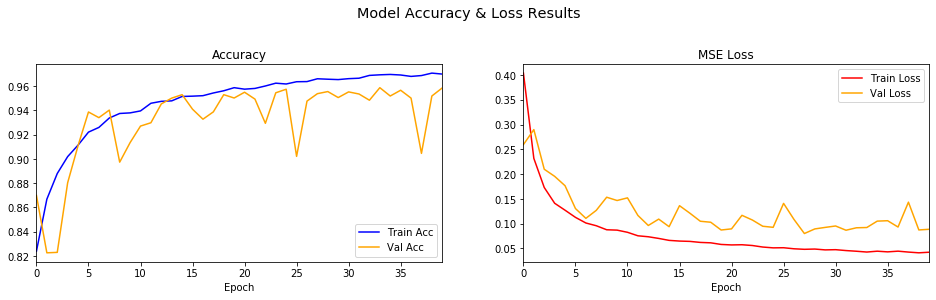

Final Val Accuracu: 0.9584


0.9584

In [536]:
adadelta = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
model = gen_cnn('relu', True, False)
model.compile(loss='mse', optimizer=adadelta, metrics=['accuracy'])
adadelta_history = model.fit(X_train, y_train, epochs=40, verbose=1, validation_data=val_data)
gen_graph(adadelta_history.history)
get_acc(model, val_data)

Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_346 (Conv1D)          (None, 187, 64)           192       
_________________________________________________________________
batch_normalization_319 (Bat (None, 187, 64)           256       
_________________________________________________________________
conv1d_347 (Conv1D)          (None, 187, 32)           2080      
_________________________________________________________________
batch_normalization_320 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_131 (MaxPoolin (None, 93, 32)            0         
_________________________________________________________________
batch_normalization_321 (Bat (None, 93, 32)            128       
_________________________________________________________________
flatten_147 (Flatten)        (None, 2976)           

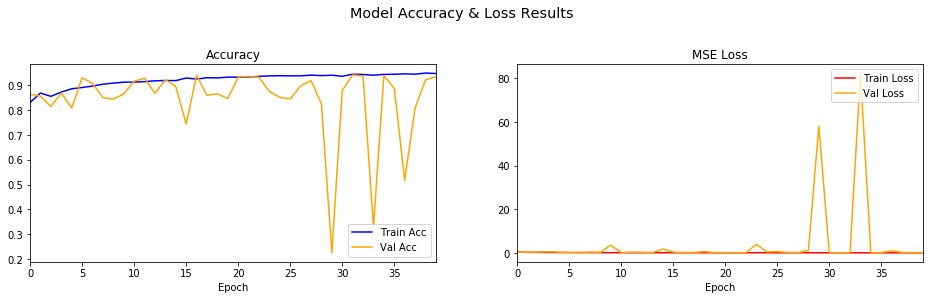

Final Val Accuracu: 0.9344


0.9344

In [537]:
adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model = gen_cnn('relu', True, False)
model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
adam_history = model.fit(X_train, y_train, epochs=40, verbose=1, validation_data=val_data)
gen_graph(adam_history.history)
get_acc(model, val_data)